# Google Colab Lab Assignment - Pretrained Model

**Course Name:** Deep Learning  
**Lab Title:** Research Paper Implementation with Pre-trained Model  
**Student Name:** Kaustubh Mahajan  
**Student ID:** 202201070128  
**Date of Submission:** 24/02/2025  
**Group Members**: [Enter Names]  

## Research Paper Study and Implementation  
**Paper Title:** Transfer Learning for Classification of Retinal Disease using Fundus Imaging  
**Dataset:** APTOS 2019  
**Pre-trained Model:** ResNet50  

---

### **Objective**  
1. Study the research paper utilizing a pre-trained model.  
2. Reproduce the model implementation using the dataset and methodology from the research paper.  
3. Fine-tune the pre-trained model and optimize hyperparameters.  
4. Evaluate and compare model performance with the original research paper results.  

---

### **Task 1: Research Paper Selection and Dataset Preparation**  

#### **Dataset: APTOS 2019**  
- APTOS 2019 dataset consists of retinal fundus images labeled for diabetic retinopathy severity.  
- Classes: No DR, Mild, Moderate, Severe, Proliferative DR  
- Dataset Link: [https://www.kaggle.com/c/aptos2019-blindness-detection](https://www.kaggle.com/c/aptos2019-blindness-detection)  

#### **Data Preprocessing:**  
1. Resize images to match ResNet50 input dimensions (224x224).  
2. Normalize pixel values between 0 and 1.  
3. Apply data augmentation techniques.  
4. Split dataset into **train, validation, and test** sets.  



---






In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix



In [3]:
#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "notkaustubhmahajan" # username from the json file
os.environ['KAGGLE_KEY'] = "c340077f463ba5dbb716c86ef16e8232" # key from the json file

!kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [02:18<00:00, 82.9MB/s]
100% 9.51G/9.51G [02:18<00:00, 73.8MB/s]


In [10]:
!unzip -q aptos2019-blindness-detection.zip -d aptos2019_data

In [11]:
DATASET_PATH = "aptos2019_data/"
 # Changed DATASET_PATH to the correct directory after unzipping the file.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH, # Using the same DATASET_PATH for validation as well. It uses the validation_split argument to create a validation set.
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 4473 images belonging to 2 classes.
Found 1117 images belonging to 2 classes.


### **Task 2: Model Implementation and Fine-tuning**  

#### **Pre-trained Model: ResNet50**  
- Load ResNet50 model with ImageNet weights.  
- Freeze initial layers and modify top layers.  
- Optimize hyperparameters.  



---

In [13]:
# Load Pre-trained ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers[:]:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)  # 5 output classes

# Define model
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 74,969,474 (285.99 MB)

 Trainable params: 51,381,762 (196.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1735s 12s/step - accuracy: 0.7831 - loss: 2.4891 - val_accuracy: 0.8917 - val_loss: 0.3576
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1764s 13s/step - accuracy: 0.8901 - loss: 0.3237 - val_accuracy: 0.8926 - val_loss: 0.3190
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1753s 13s/step - accuracy: 0.8856 - loss: 0.3391 - val_accuracy: 0.8935 - val_loss: 0.3133
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1712s 12s/step - accuracy: 0.8976 - loss: 0.3022 - val_accuracy: 0.8944 - val_loss: 0.3106
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1728s 12s/step - accuracy: 0.9011 - loss: 0.2710 - val_accuracy: 0.8988 - val_loss: 0.2970
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1749s 12s/step - accuracy: 0.9050 - loss: 0.2720 - val_accuracy: 0.8962 - val_loss: 0.3113
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1711s 12s/step - accuracy: 0.9003 - loss: 0.2750 - val_accuracy: 0.8944 - val_loss: 0.2992
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1708s 12s/step - accuracy: 0.9008 - loss: 0


### **Task 3: Model Evaluation and Performance Comparison**  

#### **Evaluation Metrics:**  
- Accuracy  
- Precision, Recall, F1-score  
- Confusion Matrix  



---

35/35 ━━━━━━━━━━━━━━━━━━━━ 343s 9s/step
              precision    recall  f1-score   support

 test_images       0.34      0.26      0.29       385
train_images       0.65      0.73      0.69       732

    accuracy                           0.57      1117
   macro avg       0.49      0.50      0.49      1117
weighted avg       0.54      0.57      0.55      1117

Confusion Matrix: [[ 99 286]
 [195 537]]


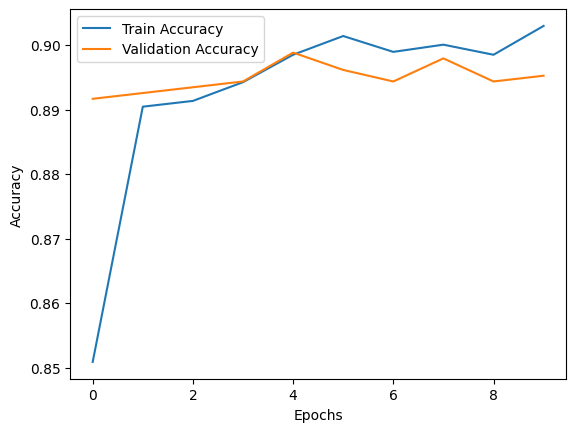

In [14]:
# Evaluate model
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys())))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:", conf_matrix)

# Plot training history
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### **Conclusion and Result Visualization**  
- Discuss findings and performance comparison with the research paper.  

---

### **Declaration**  
I, Kaustubh Mahajan, confirm that the work submitted in this assignment is my own and follows academic integrity guidelines. The code is uploaded to my GitHub repository, and the link is provided below:  

**GitHub Repository Link:** [Insert GitHub Link]  

**Signature:** Kaustubh Satish Mahajan  